## gan

In [31]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_dim) -> None:
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

class Generator(nn.Module):
    def __init__(self, z_dim, output_dim) -> None:
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)


## hyperparameters

In [27]:
print(f'CUDA available: {torch.cuda.is_available()}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-4
z_dim = 64
img_dim = 28*28
batch_size = 32
epochs = 200


CUDA available: True


## load data

In [32]:
import torchvision
import torchvision.transforms as transforms

t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./mnist/', train=True, download=False, transform=t)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

dis = Discriminator(input_dim=img_dim).to(device)
gen = Generator(z_dim=z_dim, output_dim=img_dim).to(device)

optim_dis = torch.optim.Adam(dis.parameters(), lr)
optim_gen = torch.optim.Adam(gen.parameters(), lr)
criterion = nn.BCELoss()

## train

Epoch 0: dloss 0.4537491202354431     gloss 1.377995252609253


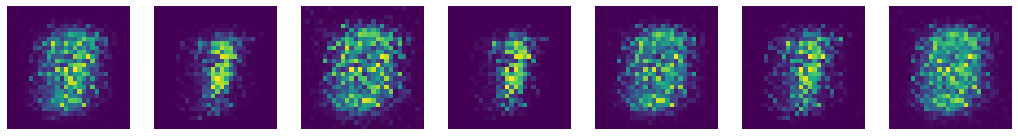

Epoch 5: dloss 0.5195431709289551     gloss 1.3499189615249634


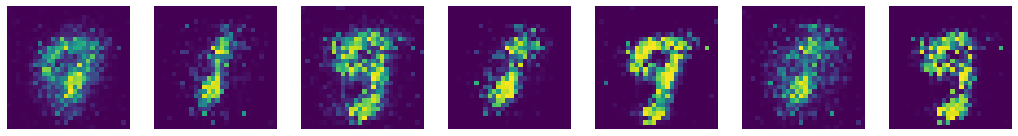

Epoch 10: dloss 0.3004104495048523     gloss 1.7751057147979736


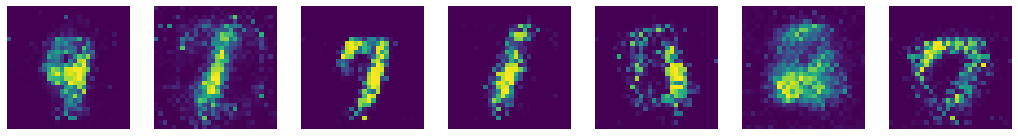

Epoch 15: dloss 0.4555506110191345     gloss 1.8958261013031006


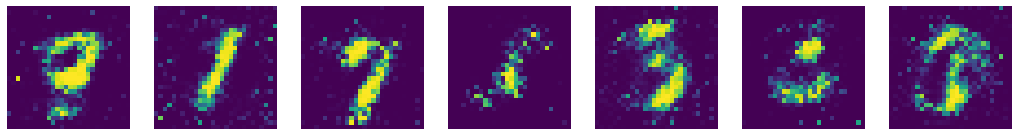

Epoch 20: dloss 0.5196166038513184     gloss 1.1884829998016357


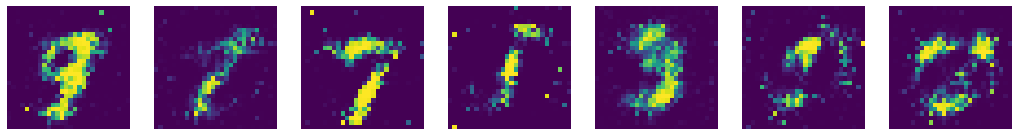

Epoch 25: dloss 0.600011944770813     gloss 1.1175329685211182


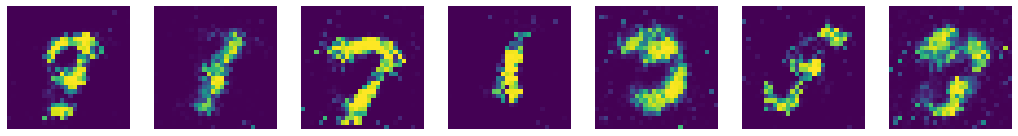

Epoch 30: dloss 0.6672186851501465     gloss 0.8351536989212036


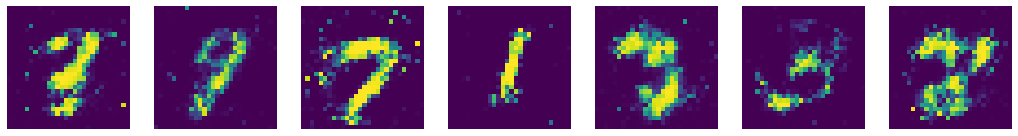

Epoch 35: dloss 0.6368157863616943     gloss 1.048357605934143


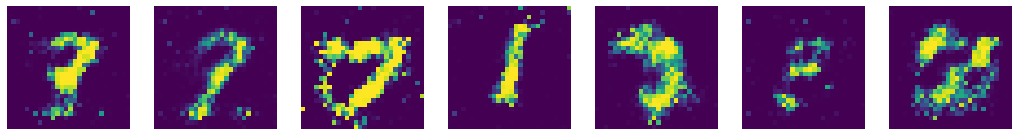

Epoch 40: dloss 0.636940598487854     gloss 0.9853867292404175


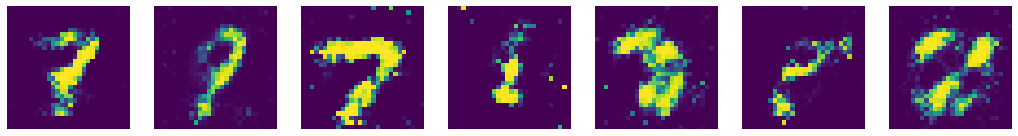

Epoch 45: dloss 0.6110520362854004     gloss 1.0205672979354858


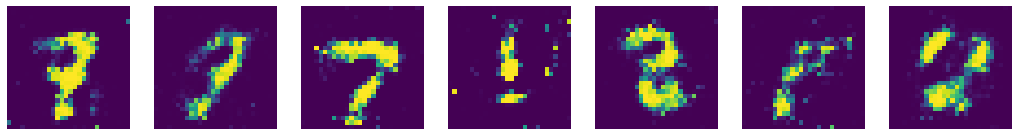

Epoch 50: dloss 0.6207160949707031     gloss 0.8348912000656128


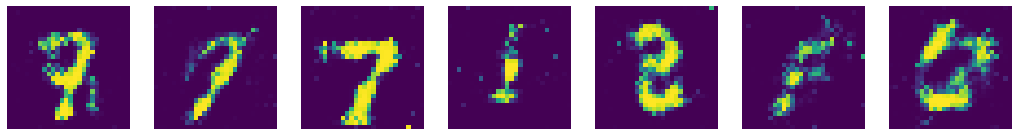

Epoch 55: dloss 0.6899467706680298     gloss 0.8563109040260315


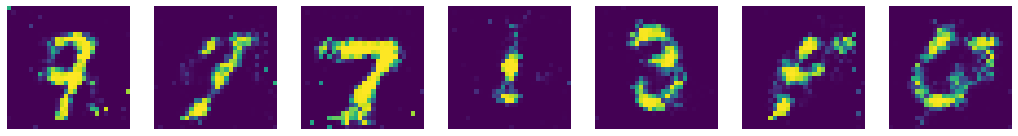

Epoch 60: dloss 0.6229203939437866     gloss 0.7893639802932739


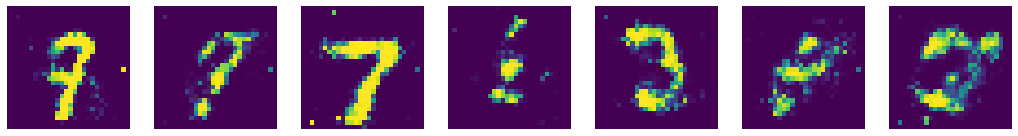

Epoch 65: dloss 0.6336096525192261     gloss 0.7683455944061279


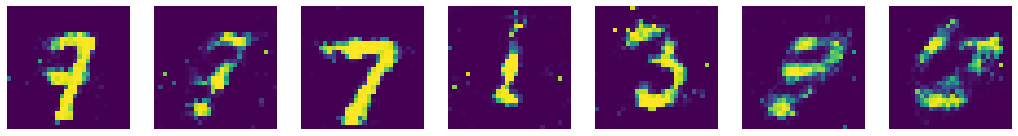

Epoch 70: dloss 0.7023314237594604     gloss 0.8810948133468628


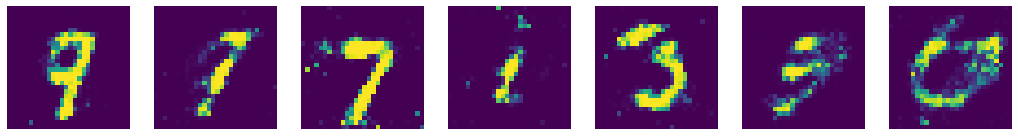

Epoch 75: dloss 0.5419958829879761     gloss 1.1501784324645996


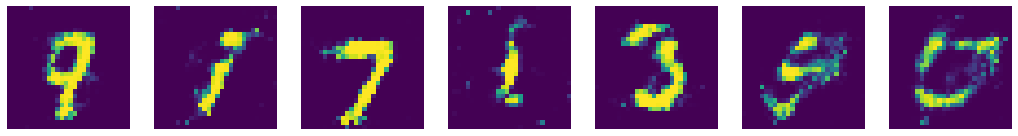

Epoch 80: dloss 0.6018137335777283     gloss 0.9720759391784668


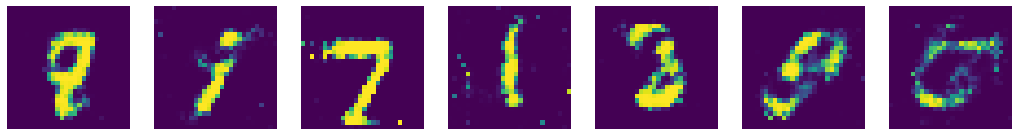

Epoch 85: dloss 0.6840522289276123     gloss 1.0165833234786987


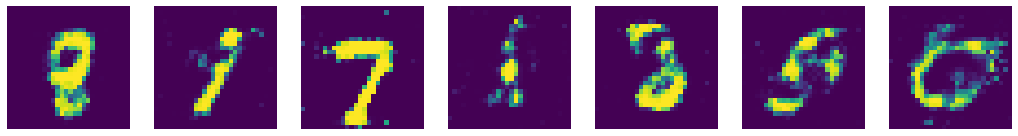

Epoch 90: dloss 0.6464632749557495     gloss 0.8122928142547607


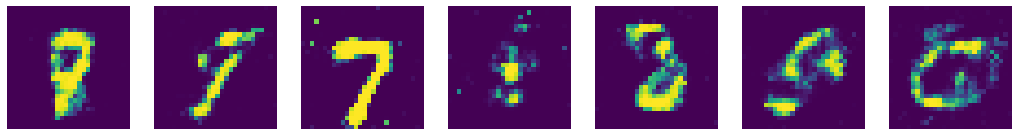

Epoch 95: dloss 0.5682872533798218     gloss 0.957085132598877


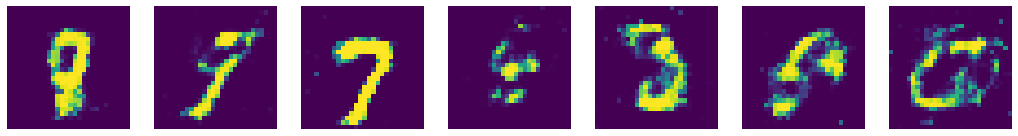

Epoch 100: dloss 0.6755032539367676     gloss 0.9632077813148499


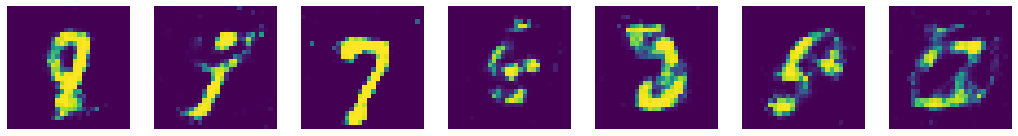

Epoch 105: dloss 0.7104142308235168     gloss 1.0253279209136963


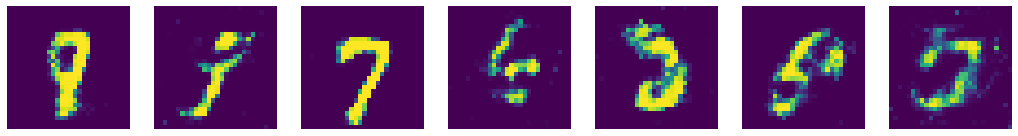

Epoch 110: dloss 0.6439110040664673     gloss 1.2459735870361328


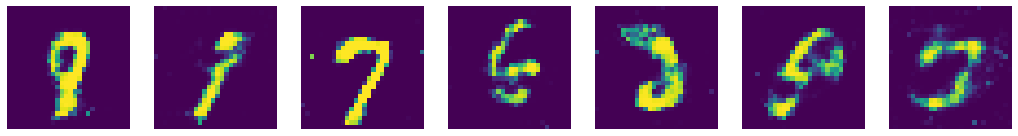

Epoch 115: dloss 0.5850199460983276     gloss 0.8543806672096252


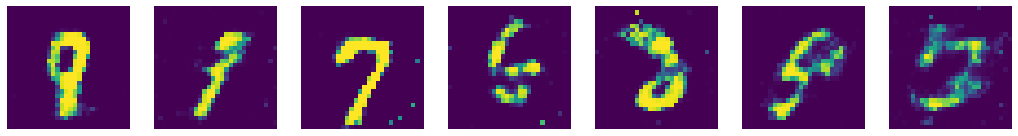

Epoch 120: dloss 0.5563700199127197     gloss 0.9051896333694458


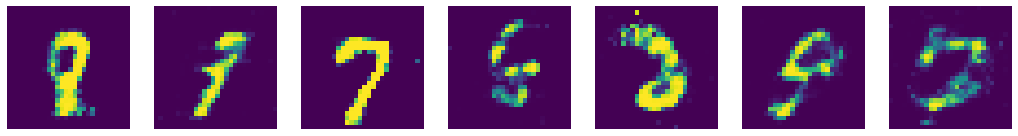

Epoch 125: dloss 0.5284336805343628     gloss 0.786389172077179


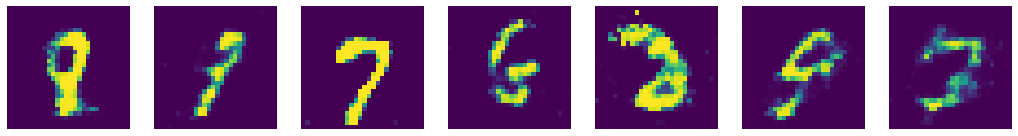

Epoch 130: dloss 0.6527708172798157     gloss 0.9991984367370605


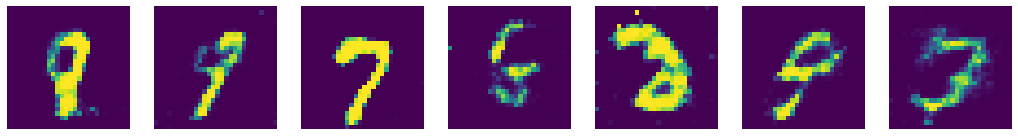

Epoch 135: dloss 0.4621489346027374     gloss 1.2012758255004883


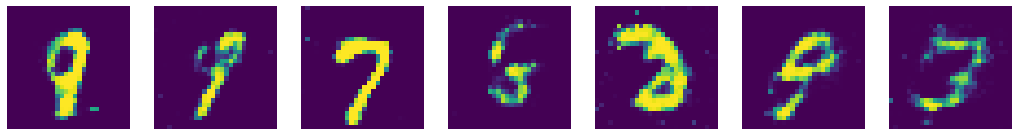

Epoch 140: dloss 0.5874407291412354     gloss 1.1838665008544922


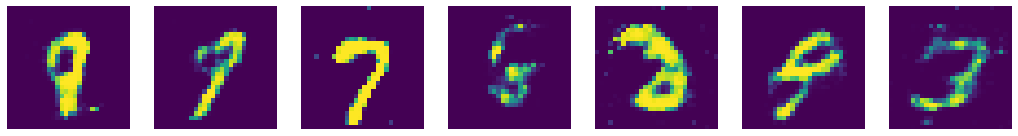

Epoch 145: dloss 0.6354149580001831     gloss 0.9358305931091309


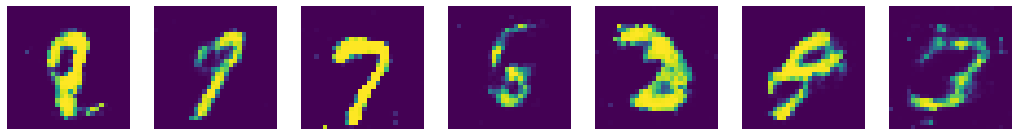

Epoch 150: dloss 0.5797467827796936     gloss 0.9146369695663452


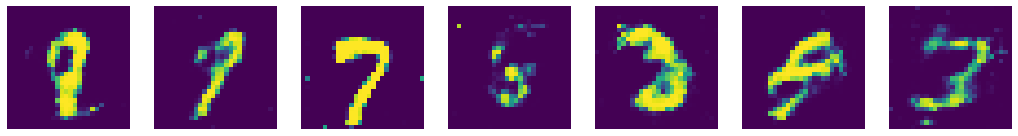

Epoch 155: dloss 0.5081168413162231     gloss 1.1280953884124756


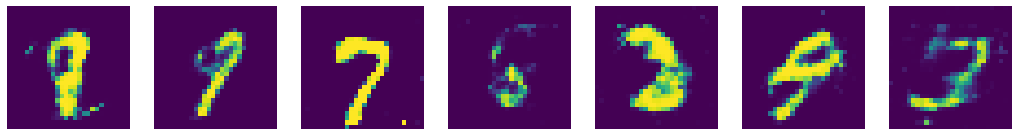

Epoch 160: dloss 0.683060884475708     gloss 1.0795364379882812


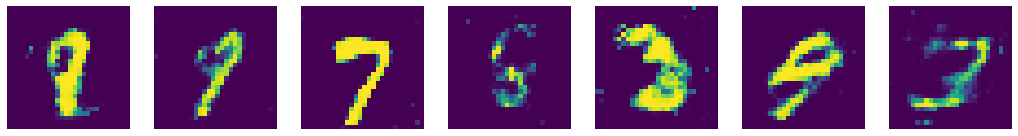

Epoch 165: dloss 0.6133018732070923     gloss 0.9258751273155212


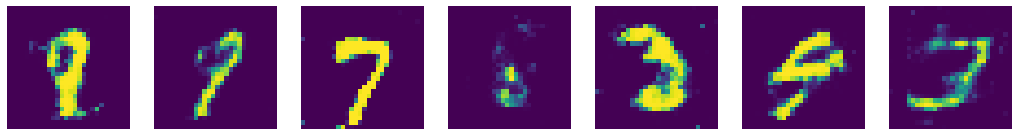

Epoch 170: dloss 0.5649991631507874     gloss 1.1871609687805176


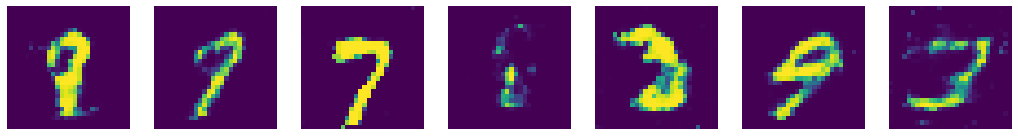

Epoch 175: dloss 0.5893052220344543     gloss 0.9023172855377197


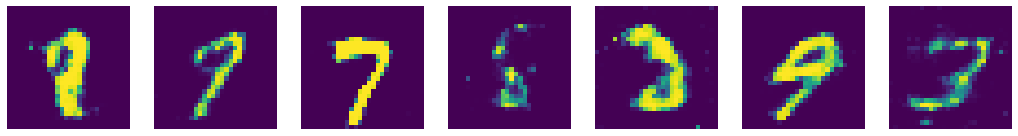

Epoch 180: dloss 0.644711971282959     gloss 0.866809606552124


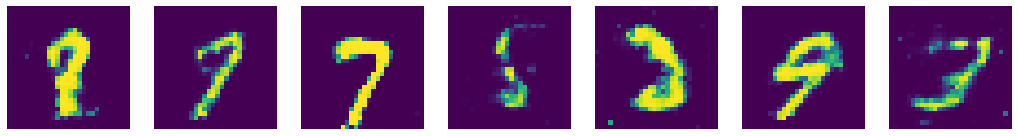

Epoch 185: dloss 0.5538505911827087     gloss 1.1178441047668457


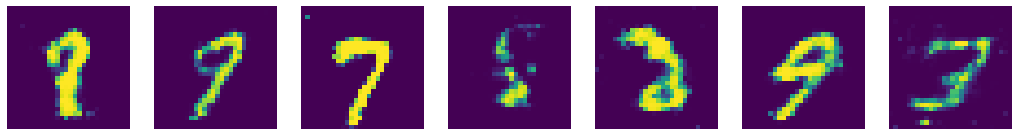

Epoch 190: dloss 0.47182145714759827     gloss 1.1317288875579834


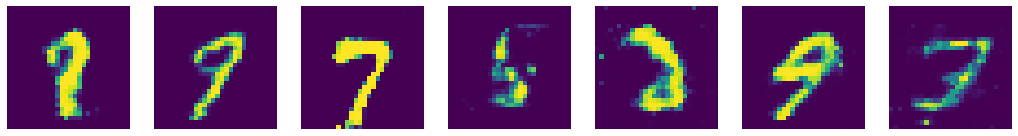

Epoch 195: dloss 0.512818455696106     gloss 1.0922809839248657


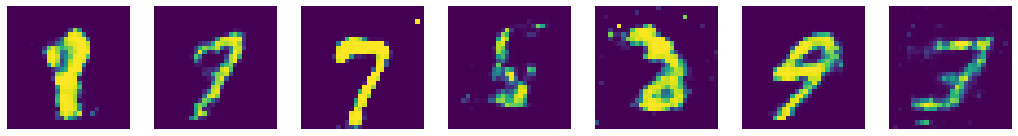

In [34]:
import matplotlib.pyplot as plt
import numpy

dlosses, glosses = [], []
fixed_noise = torch.randn(7, z_dim).to(device)

for epoch in range(epochs):
    for idx, (real, _) in enumerate(dataloader):
        real = real.view(-1, 784).to(device)
        noise = torch.randn(batch_size, z_dim).to(device)
        
        # discriminator
        fake = gen(noise)
        dis_real = dis(real).view(-1)
        loss_dis_real = criterion(dis_real, torch.ones_like(dis_real))
        dis_fake = dis(fake).view(-1)
        loss_dis_fake = criterion(dis_fake, torch.zeros_like(dis_fake))
        loss_dis = (loss_dis_real + loss_dis_fake)/2
        dis.zero_grad()
        loss_dis.backward(retain_graph=True)
        optim_dis.step()

        # generator
        output = dis(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optim_gen.step()

        if idx%100 == 0:
            dlosses.append(loss_dis.detach().item())
            glosses.append(loss_gen.detach().item())
    
    
    if epoch%5 == 0:
        print(f'Epoch {epoch}: dloss {loss_dis}     gloss {loss_gen}')

        # visualize
        fake = gen(fixed_noise)
        fake = fake.reshape([7,28,28])
        fig, axs = plt.subplots(1, 7, figsize=(18,5))

        for i in range(7):
            data = fake[i].cpu().detach().numpy()
            axs[i].imshow(data)
        for ax in axs:
            ax.axis('off')

        plt.show()
    

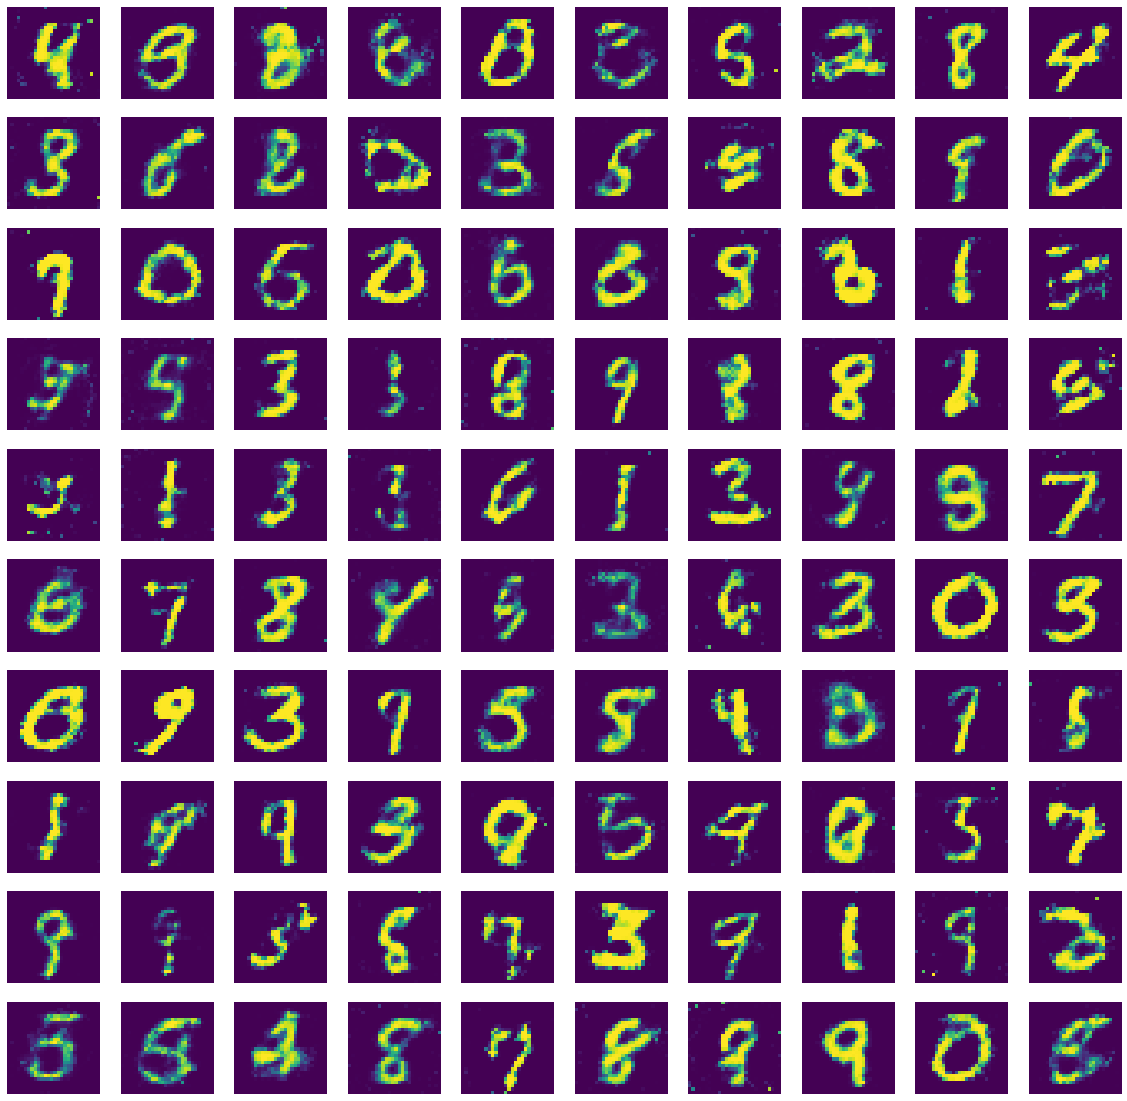

In [36]:
noise = torch.randn(100, z_dim).to(device)
fake = gen(noise)
fake = fake.reshape([100,28,28])
fig, axs = plt.subplots(10, 10, figsize=(20,20))
for i, ax in enumerate(axs.flat):
    data = fake[i].cpu().detach().numpy()
    ax.imshow(data)
    ax.axis('off')

plt.show()

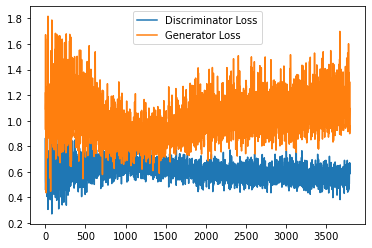

In [35]:
plt.figure()
plt.plot(dlosses[:], label="Discriminator Loss")
plt.plot(glosses[:], label="Generator Loss")
plt.legend()
